In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import histlite as hl
import csky as cy
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats

In [2]:
mpl.rcParams['font.size'] = 20

In [3]:
ana_dir = cy.utils.ensure_dir('/home/jthwaites/csky_cache')
#ana = cy.get_analysis(cy.selections.repo, 'version-002-p05', cy.selections.GFUDataSpecs.GFU_IC86, 
#                dir=ana_dir)
ana = cy.get_analysis(cy.selections.repo, 'version-002-p05', cy.selections.GFUDataSpecs.GFU_IC86_2011_2018, 
                dir=ana_dir)

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2013_data.npy ...
Reading /data/a

In [4]:
conf = {'extended': True,
        'space': "ps",
        'time': "transient",
        'sig': 'transient',
        'ana':ana,
        }
cy.CONF.update(conf)

In [5]:
cy.CONF

{'mp_cpus': 1,
 'extended': True,
 'space': 'ps',
 'time': 'transient',
 'sig': 'transient',
 'ana': Analysis(keys=[GFU_for_2011_2012_2013_2014_2015_2016_2017_2018])}

In [11]:
def load_frbs(make_skymap=False):
    with open('./catalog/repeaters.txt') as json_file:
        repeaters = json.load(json_file)

    rep_source={'src':[],'coord':[],'mjd':[]}
    ra=[]
    dec=[]
    for source in repeaters: 
        rep_source['src'].append(source)
        ra.append(repeaters[source]['ra']['value'])
        dec.append(repeaters[source]['dec']['value'])    
        times=[]
        for key in repeaters[source]:
            if key != 'dm' and key !='ymw16' and key!='dec' and key!='gl' and key!='gb' and key!= 'ra' and \
                key!='localized' and key!='last_burst_date' and key!='publication' and key!='ne2001' and \
                key!='previous_name': 
                times.append(Time(repeaters[source][key]['timestamp']['value'],format ='iso').mjd)
        rep_source['mjd'].append(times)
    
    rep_source['coord']=SkyCoord(ra=ra,dec=dec, unit=(u.hourangle,u.deg))
    frbs = pd.read_csv('./catalog/frbs_wout_chime.csv')
    unique_frbs, frb_ind_all, n_frbs = np.unique(frbs['frb_name'].values, return_index=True, return_counts=True)
    frb_ind_all=frbs['frb_name'].index[frb_ind_all]
    
    frbs_coord = SkyCoord(ra=frbs['rop_raj'], dec=frbs['rop_decj'], unit=(u.hourangle, u.deg))
    frbs_mjd = np.asarray([Time(t.replace('/', '-'), format='iso').mjd for t in frbs['utc']])
    
    #choose northern FRB: 33 deg dec for FRB121102
    wn=np.where(frbs['frb_name']=='FRB121102')
    wn=wn[0][0] #want only one of the bursts
    #choose southern FRB: -35 deg dec for FRB180110
    ws=np.where(frbs['frb_name']=='FRB180110')
    ws=ws[0][0]
    
    all_ras=[]
    all_dec=[]
    all_mjd=[]
    for i in range(len(frbs_coord.ra)):
        all_ras.append(frbs_coord[i].ra.rad)
        all_dec.append(frbs_coord[i].dec.rad)
        all_mjd.append(frbs_mjd[i])

    for i in range(len(rep_source['src'])):
        for j in range(len(rep_source['mjd'][i])):
            all_ras.append(rep_source['coord'][i].ra.rad)
            all_dec.append(rep_source['coord'][i].dec.rad)
            all_mjd.append(rep_source['mjd'][i][j])
    if make_skymap==True:
        unique_frbs_coord = SkyCoord(ra=frbs['rop_raj'].reindex(frb_ind_all).values, 
                      dec=frbs['rop_decj'].reindex(frb_ind_all).values, 
                      unit=(u.hourangle, u.deg))
        dec=[d for d in unique_frbs_coord.dec.rad]
        dec2=[d for d in rep_source['coord'].dec.rad]
        ra=[d for d in unique_frbs_coord.ra.rad]
        ra2=[d for d in rep_source['coord'].ra.rad]
        make_frb_skymap(ra+ra2,dec+dec2)
        
    return all_ras, all_dec, all_mjd, wn, ws

In [7]:
#build source object
def sources(t_s, index=False): #time window (sec)
    if index==False:
        src = cy.utils.Sources(
            ra=all_ras,
            dec=all_dec, 
            mjd=all_mjd,
            t_100=[t_s/84600.]*len(all_ras), #in mjd
            sigma_t=[0.]*len(all_ras),
            deg=False)
    else:
        src = cy.utils.Sources(
            ra=all_ras[index],
            dec=all_dec[index], 
            mjd=all_mjd[index],
            t_100=[t_s/84600.], #in mjd
            sigma_t=[0.],
            deg=False)
    return src

def make_frb_skymap(ra, dec, print_plot=True):    
    src_map = hl.heal.hist(128, dec, ra)

    fig, ax = plt.subplots(figsize=(10,6),subplot_kw=dict(projection='aitoff'))
    sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap='Blues',vmin=0))
    mesh, cb = sp.plot_map(ax, np.where(src_map.map>0, src_map.map, np.nan), n_ticks=2)
    kw = dict(color='.5', alpha=.5)
    sp.plot_gp(ax, lw=.5, **kw)
    sp.plot_gc(ax, **kw)
    ax.grid(**kw)
    plt.title('Skymap of FRB locations \n')
    cb.set_label(r'FRBs/bin')
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/frb_skymap.png')

In [12]:
all_ras, all_dec, all_mjd,wn,ws =load_frbs(make_skymap=False)

In [13]:
def bg_ts_trials(src, n_trials=10000, frb_name = ' ', print_plot=False):
    tr=cy.get_trial_runner(conf,ana=ana,src=src)
    
    #running bg trials
    trials=tr.get_many_fits(n_trials)
    bg = cy.dists.Chi2TSD(trials)
    if np.count_nonzero(trials.ts)==0:
        print('no nonzero TS values')
    
    if print_plot==True: 
        fig, ax = plt.subplots(figsize=(9,6))
        h = bg.get_hist(bins=50)
        hl.plot1d(ax, h, crosses=True, label='%i bg trials'%(bg.n_total))

        # compare with the chi2 fit:
        x = h.centers[0][1:] #remove zero TS bin from curve: not fitted here
        norm = h.integrate().values #normalization for chi-sq
        ax.semilogy(x, norm * bg.pdf(x), lw=1, label=r'$\chi^2$[%.2f dof, $\eta$=%.3f]'%(bg.ndof, bg.eta))

        ax.set_xlabel(r'TS')
        ax.set_ylabel(r'$N$')
        if src['t_100'][0]==1.: plt.title(r'BG TS distribution, %s (1d)'%(frb_name))
        else: plt.title(r'BG TS distribution, %s (%is)'%(frb_name,src['t_100'][0]*84600.))
        ax.legend()
        plt.savefig('./plots/%s_bgts_%is.png'%(frb_name,int(src['t_100'][0]*84600.)))
    return bg

In [14]:
def sens_dp(src, beta=0.9, nsigma=5, gamma=2., n_trials=10000, logging=False): #beta is %, nsigma is # of sigma for dp
    bg=bg_ts_trials(src, n_trials)
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(gamma)})
    #sensitivity
    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_batches=10,n_sig_step=1, logging=logging)
    #discovery potential
    disc = tr.find_n_sig(bg.isf_nsigma(nsigma), beta, tol=0.03,n_batches=10,n_sig_step=1, logging=logging)
    return sens, disc

def pf_plot(src, sens, disc, nsigma=5, gamma=2., frb_name=' ', print_plot=False, show_chisq=True):
    fig, ax = plt.subplots(figsize=(9,6))
    mpl.rcParams['font.size'] = 15
    
    xs = np.linspace(0., max(sens['info']['n_sigs']), 500)
    xs_dp = np.linspace(0., max(disc['info']['n_sigs']), 500)
    
    chi2cdf = lambda n: stats.chi2.cdf(n, *sens['info']['params'])
    chi2cdf_dp = lambda n: stats.chi2.cdf(n, *disc['info']['params'])
    
    plt.errorbar(sens['info']['n_sigs'], sens['info']['CLs'], 
             yerr=sens['info']['sigmas'], label = 'Sensitivity')
    plt.errorbar(disc['info']['n_sigs'],disc['info']['CLs'], 
             yerr=disc['info']['sigmas'], label = r'%i$\sigma$ Discovery potential'%nsigma)
    
    if show_chisq==True:
        plt.plot(xs, chi2cdf(xs), label = 'sensitivity Chi2CDF fit')
        plt.axvline(sens['info']['n_sig_chi2cdf'], ls='--')
        plt.plot(xs_dp, chi2cdf_dp(xs_dp), label = 'DP Chi2CDF fit')
        plt.axvline(disc['info']['n_sig_chi2cdf'], ls='--')
        
    plt.legend(loc=4)
    plt.xlabel(r'$n_{\mathrm{inj}}$')
    plt.ylabel(r'Fraction TS $>$ threshold')
    
    if int(src['t_100'][0]) == 1: 
        plt.title(r'passing fraction, %s (1d) $\gamma$=%.1f'%(frb_name,gamma))
    else: 
        plt.title(r'passing fraction, %s (%is) $\gamma$=%.1f'%(frb_name,src['t_100'][0]*84600., gamma))
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/%s_pf_%is_%.1f.png'%(frb_name,int(src['t_100'][0]*84600.),gamma))
    
    print('gamma=%.1f'%gamma)
    print(r'Sensitivity: %.3f +/- %.3f | DP: %.3f +/- %.3f'
          %(sens['n_sig'], sens['n_sig']*sens['n_sig_error'],disc['n_sig'], disc['n_sig']*disc['n_sig_error']))

In [15]:
src121102_1000=sources(1000., wn)
src121102_1d=sources(84600., wn)
src180110_1000=sources(1000., ws)
src180110_1d=sources(84600., ws)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


Chi2TSD(10000 trials, eta=0.003, ndof=1.294, median=0.000 (from fit 0.000))

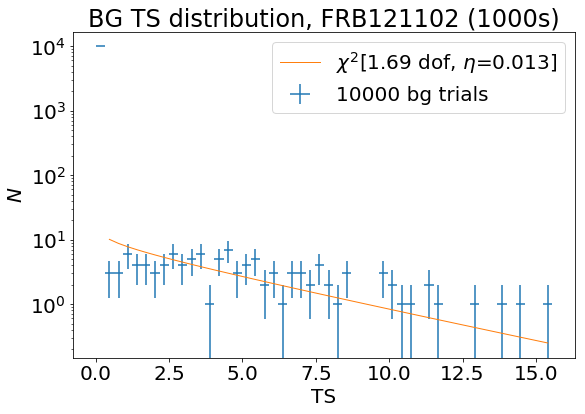

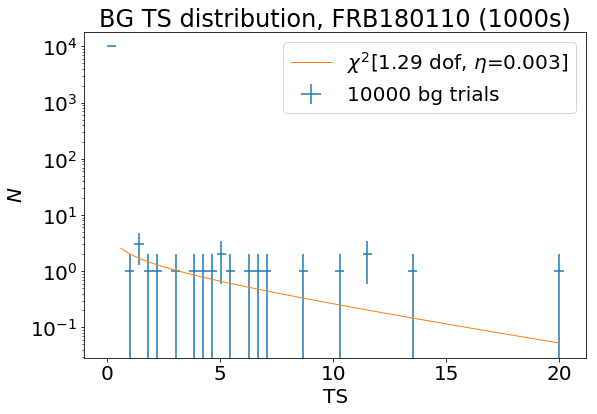

In [16]:
bg_ts_trials(src121102_1000, frb_name='FRB121102', print_plot=True)
bg_ts_trials(src180110_1000, frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


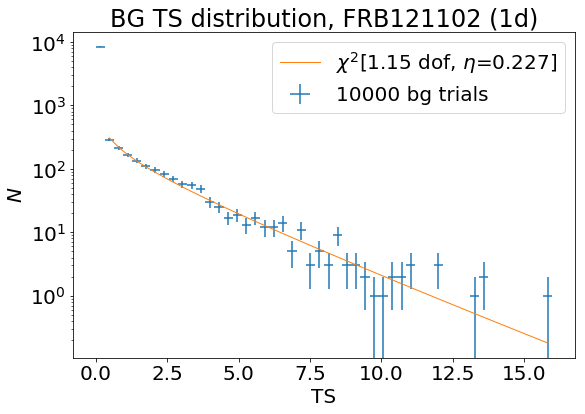

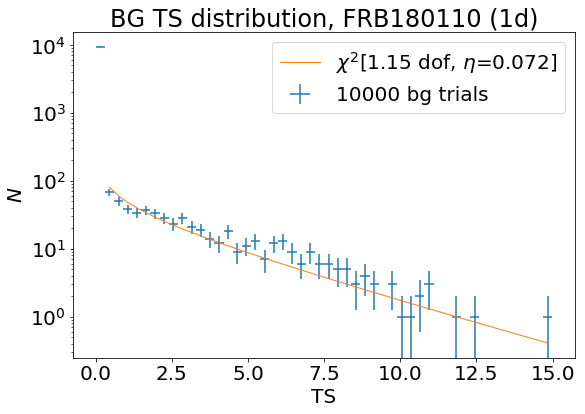

In [13]:
md_n_1d=bg_ts_trials(src121102_1d, frb_name='FRB121102', print_plot=True)
md_s_1d=bg_ts_trials(src180110_1d, frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.479 +/- 0.060 | DP: 3.912 +/- 0.099
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.327 +/- 0.067 | DP: 4.496 +/- 0.104
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.5
Sensitivity: 2.644 +/- 0.066 | DP: 3.707 +/- 0.094
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.5
Sensitivity: 2.596 +/- 0.075 | DP: 5.200 +/- 0.143
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=3.0
Sensitivity: 2.616 +/- 0.067 | DP: 4.338 +/- 0.118
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=3.0
Sensitivity: 2.892 +/- 0.075 | DP: 7.498 +/- 0.211


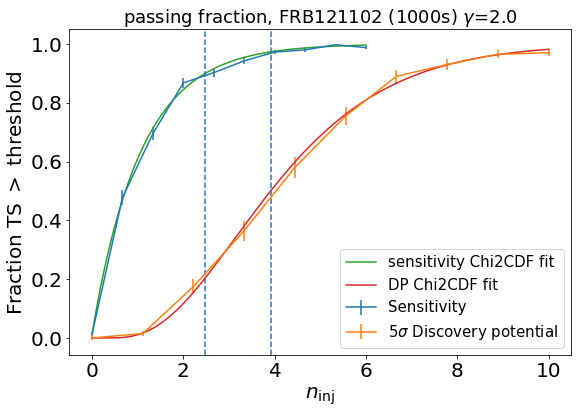

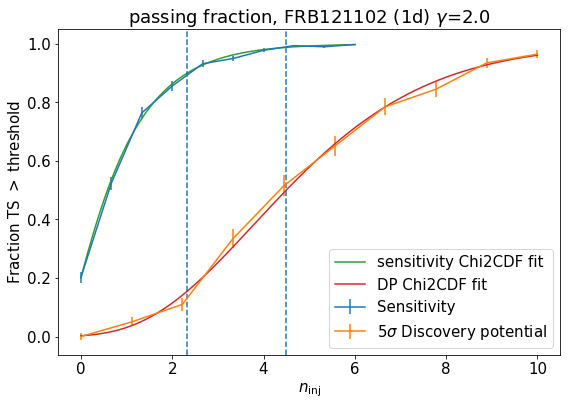

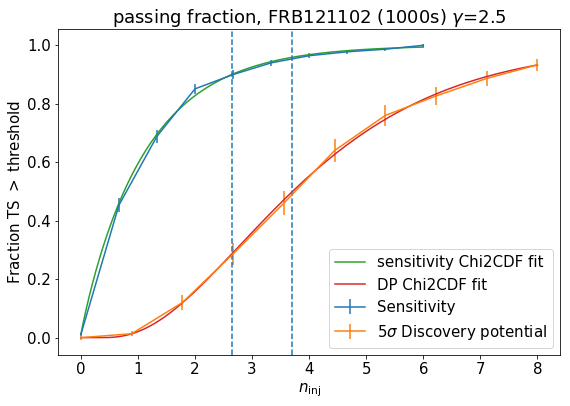

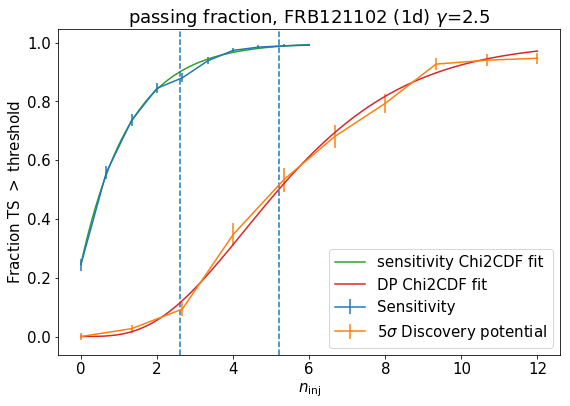

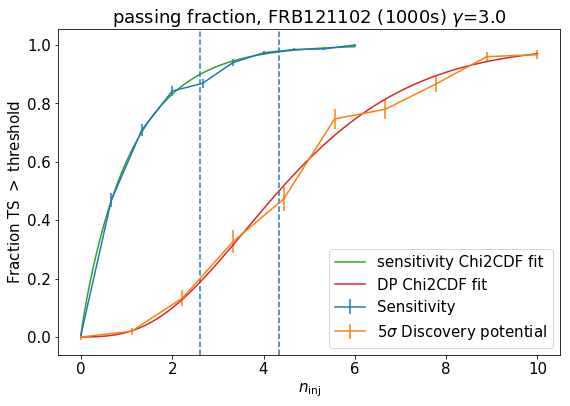

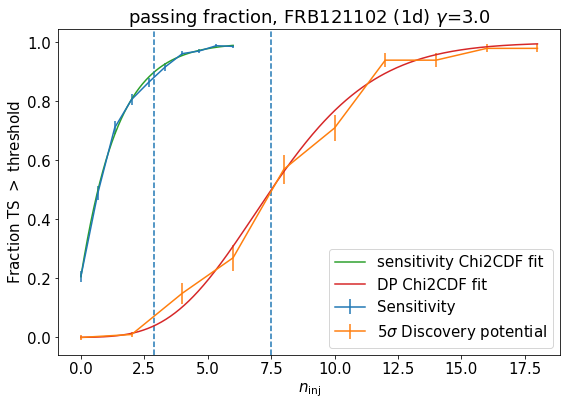

In [14]:
sens,dp = sens_dp(src121102_1000)
pf_plot(src121102_1000,sens, dp, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src121102_1d)
pf_plot(src121102_1d,sens, dp, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src121102_1000, gamma=2.5)
pf_plot(src121102_1000,sens, dp, gamma=2.5, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src121102_1d, gamma=2.5)
pf_plot(src121102_1d,sens, dp, gamma=2.5, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src121102_1000, gamma=3.)
pf_plot(src121102_1000,sens, dp, gamma=3., frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src121102_1d, gamma=3.)
pf_plot(src121102_1d,sens, dp, gamma=3., frb_name='FRB121102', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.368 +/- 0.069 | DP: 1.763 +/- 0.045
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.335 +/- 0.068 | DP: 4.323 +/- 0.130
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.5
Sensitivity: 2.335 +/- 0.060 | DP: 3.006 +/- 0.080
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.5
Sensitivity: 2.457 +/- 0.059 | DP: 4.793 +/- 0.125
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=3.0
Sensitivity: 2.390 +/- 0.060 | DP: 2.580 +/- 0.068
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=3.0
Sensitivity: 2.471 +/- 0.072 | DP: 4.397 +/- 0.129


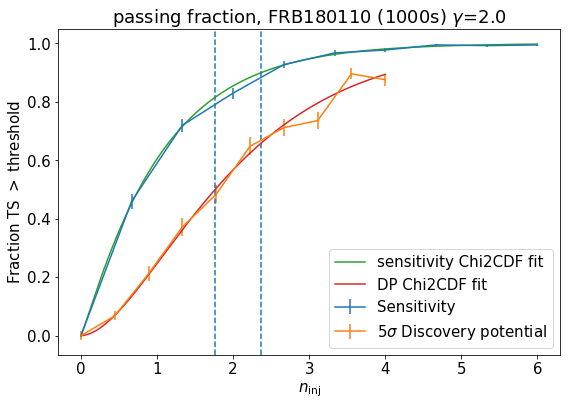

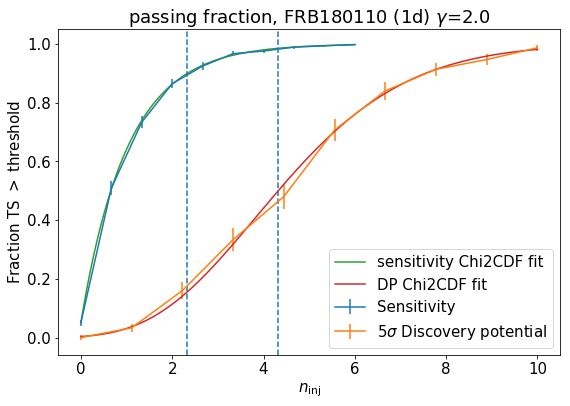

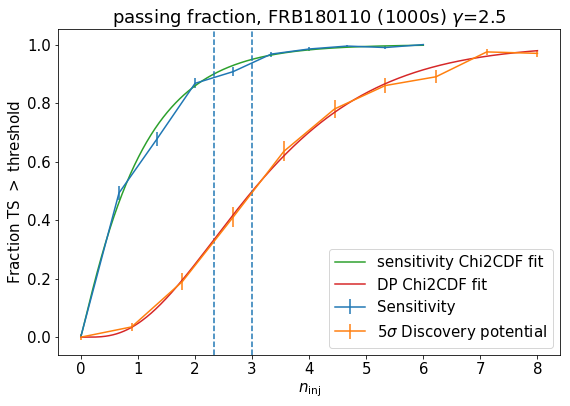

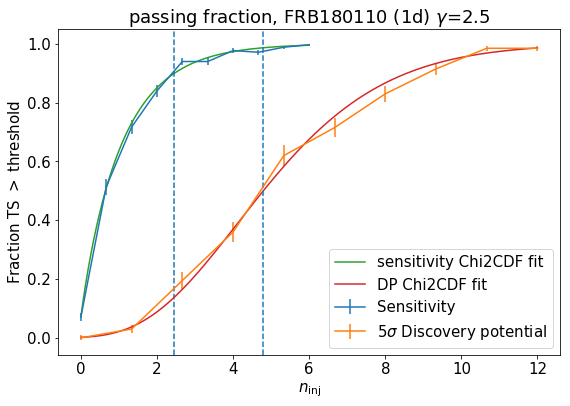

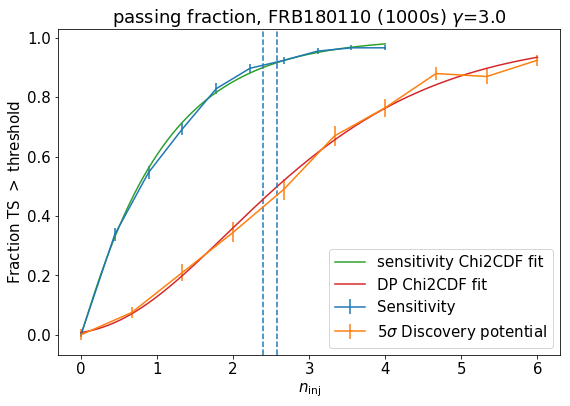

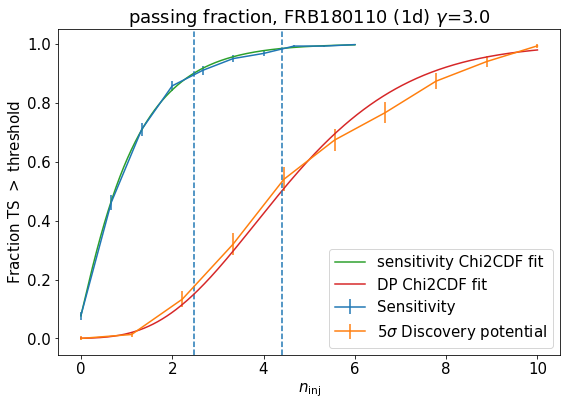

In [15]:
sens,dp = sens_dp(src180110_1000)
pf_plot(src180110_1000,sens, dp, frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src180110_1d)
pf_plot(src180110_1d,sens, dp, frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src180110_1000, gamma=2.5)
pf_plot(src180110_1000,sens, dp, gamma=2.5, frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src180110_1d, gamma=2.5)
pf_plot(src180110_1d,sens, dp, gamma=2.5, frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src180110_1000, gamma=3.)
pf_plot(src180110_1000,sens, dp, gamma=3., frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src180110_1d,gamma=3.)
pf_plot(src180110_1d,sens, dp, gamma=3., frb_name='FRB180110', print_plot=True)

### Fit bias test

In [12]:
def bias_test(src, gamma=2., nsig_max=100, frb_name=' ', print_plot=True):
    n_sigs = np.r_[:nsig_max+1:5]
    tr=cy.get_trial_runner(conf,ana=ana,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(gamma)})
    trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
    
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=2)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    ax = axs[0]
    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax = axs[1]
    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    ax.axhline(expect_gamma, **expect_kw)
    ax.set_xlim(axs[0].get_xlim())

    for ax in axs:
        ax.set_xlabel(r'$n_{inj}$')
        ax.grid()
        if int(src['t_100'][0]) == 1: 
            ax.set_title(r'%s (1d), $\gamma$=%.1f'%(frb_name,gamma))
        else: 
            ax.set_title(r'%s (%is), $\gamma$=%.1f'%(frb_name,src['t_100'][0]*84600., gamma))
        
    axs[0].set_ylabel(r'$n_s$')
    axs[1].set_ylabel(r'$\gamma$')

    if print_plot==True: plt.savefig('./plots/nbias_%s_%i_%.1f.png'%(frb_name,int(src['t_100'][0]*84600.),gamma))
    else: plt.tight_layout()

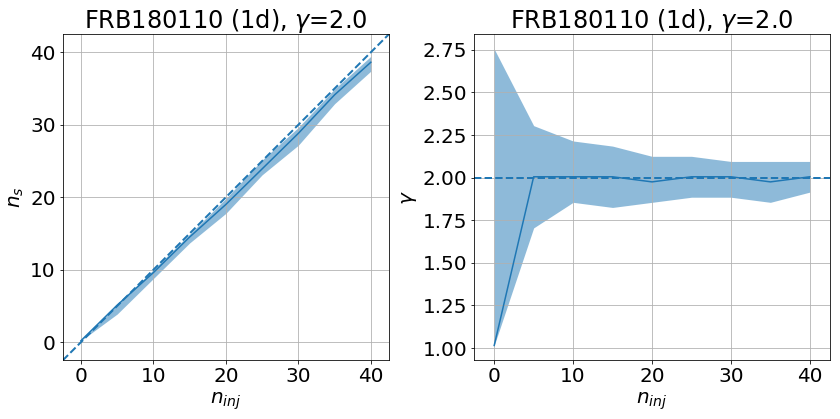

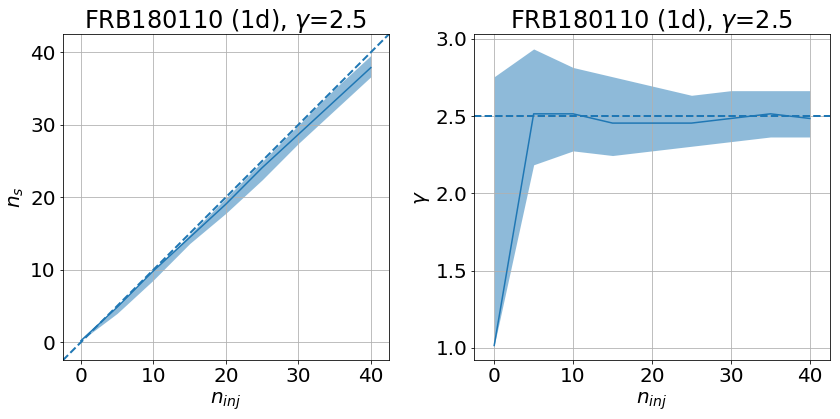

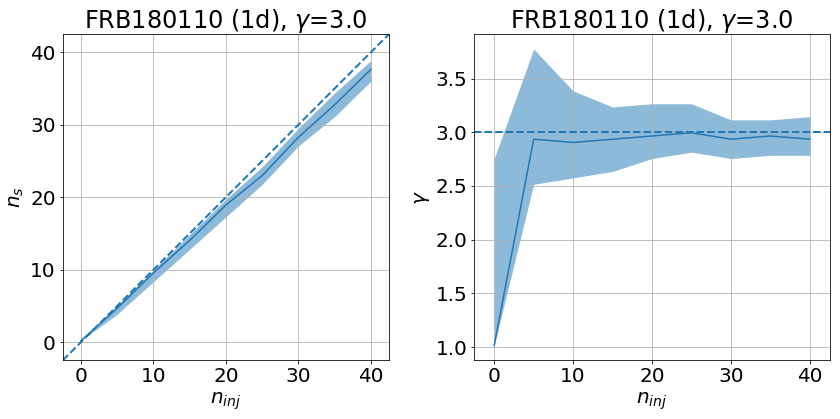

In [15]:
bias_test(src180110_1d,nsig_max=40,frb_name='FRB180110', gamma=2.)
bias_test(src180110_1d,nsig_max=40,frb_name='FRB180110', gamma=2.5)
bias_test(src180110_1d,nsig_max=40,frb_name='FRB180110', gamma=3.)

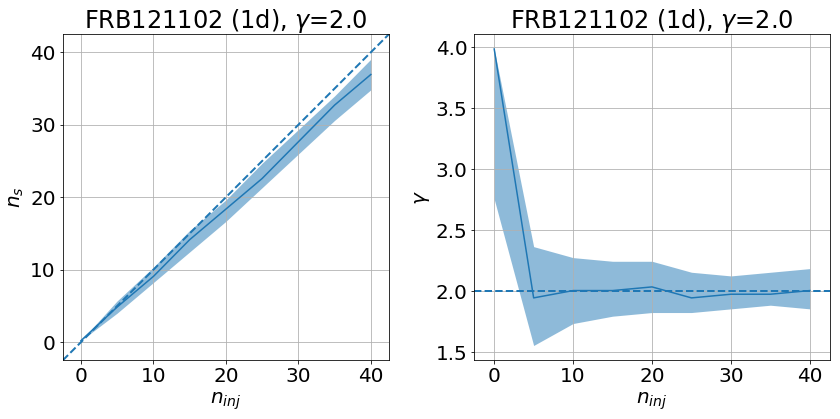

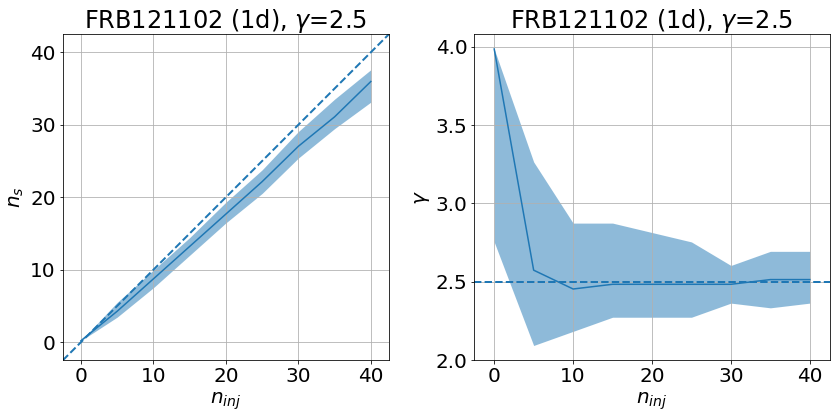

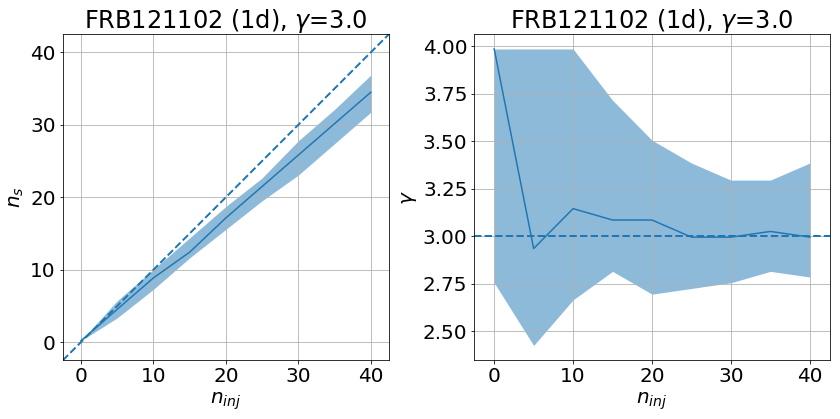

In [16]:
bias_test(src121102_1d,nsig_max=40,frb_name='FRB121102', gamma=2.)
bias_test(src121102_1d,nsig_max=40,frb_name='FRB121102', gamma=2.5)
bias_test(src121102_1d,nsig_max=40,frb_name='FRB121102', gamma=3.)

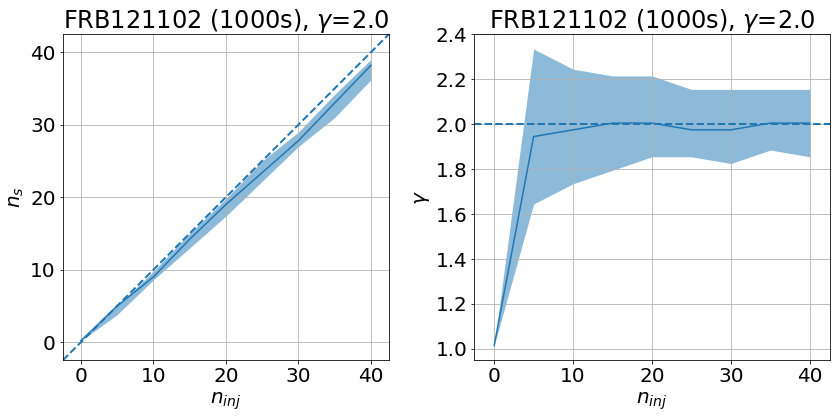

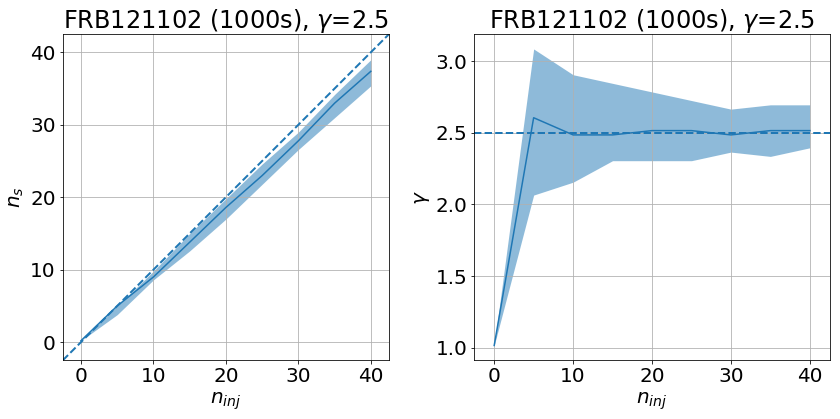

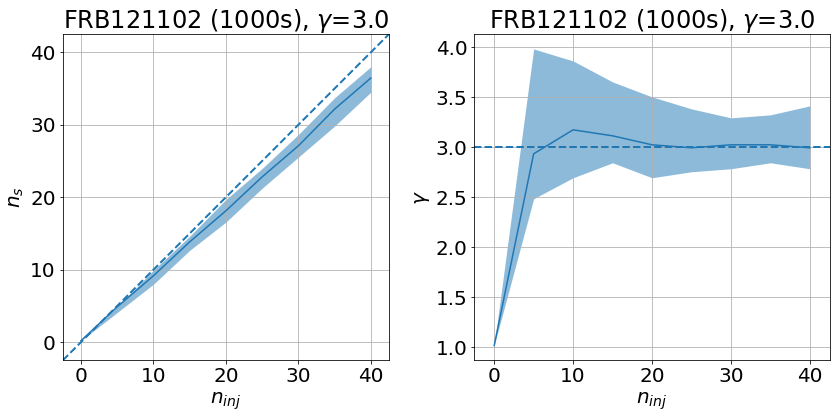

In [17]:
bias_test(src121102_1000,nsig_max=40,frb_name='FRB121102', gamma=2.)
bias_test(src121102_1000,nsig_max=40,frb_name='FRB121102', gamma=2.5)
bias_test(src121102_1000,nsig_max=40,frb_name='FRB121102', gamma=3.)

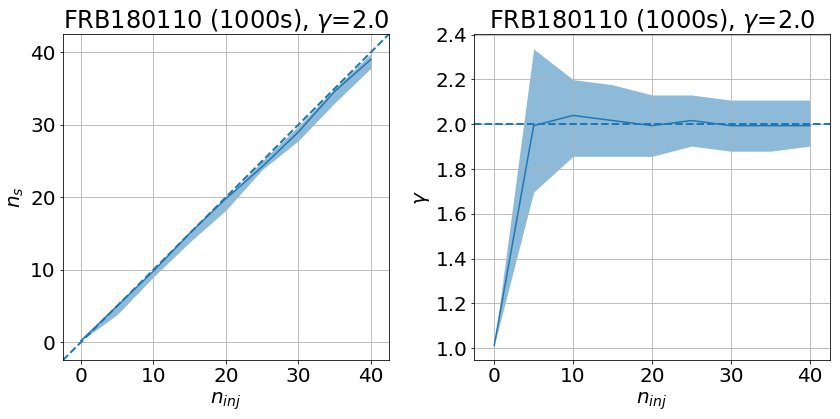

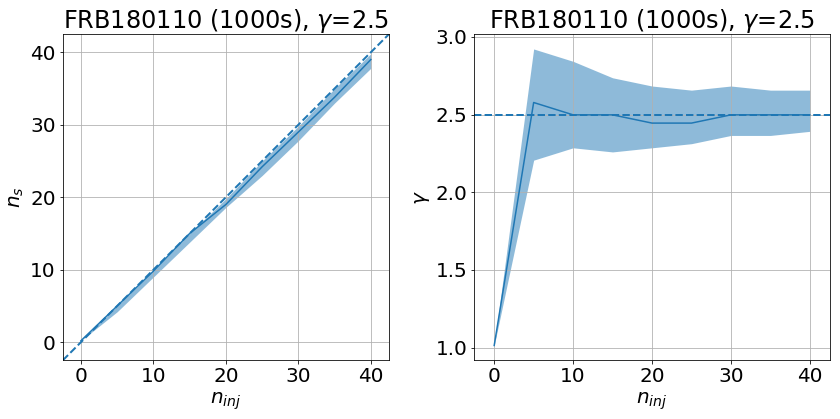

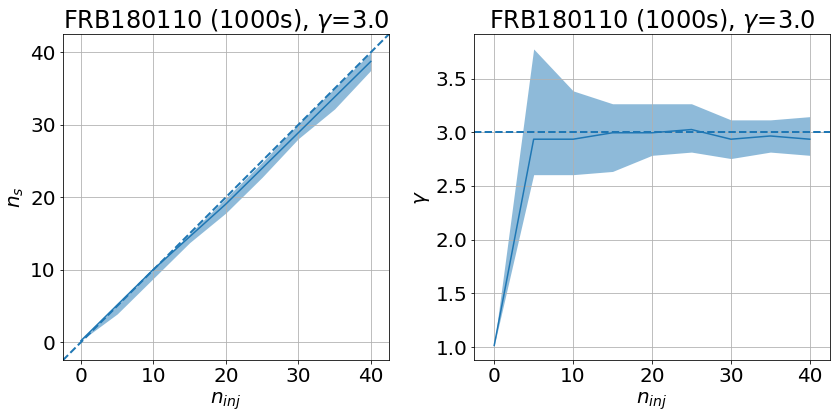

In [18]:
bias_test(src180110_1000,nsig_max=40,frb_name='FRB180110', gamma=2.)
bias_test(src180110_1000,nsig_max=40,frb_name='FRB180110', gamma=2.5)
bias_test(src180110_1000,nsig_max=40,frb_name='FRB180110', gamma=3.)

In [ ]:
#print(tr.to_E2dNdE(sens, E0=100, unit=1e3))#100 TeV cm^-2 
#print(tr.to_E2dNdE(sens))
#print(tr.to_E2dNdE(sens, E0=1, unit=1))#GeV cm^-2

### Sens/DP at different times

In [22]:
def sens_dp_dt(t_100,src_ind=False,beta=0.9, nsigma=5, n_trials=50000, logging=True): 
    #beta is %, nsigma is # of sigma for dp
    srcs=sources(t_100, index=src_ind)
    
    tr=cy.get_trial_runner(conf,ana=ana,src=srcs)
    trials=tr.get_many_fits(n_trials, logging=False)
    if np.count_nonzero(trials.ts)==0: return
    
    bg = cy.dists.Chi2TSD(trials)
    tr=cy.get_trial_runner(conf,ana=ana,src=srcs,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})

    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_sig_step=1, logging=False)
    disc = tr.find_n_sig(bg.isf_nsigma(nsigma), beta, tol=0.03,n_sig_step=1, logging=False)
    if logging==True: print("sensitivity: %.3f +/- %.3f | DP: %.3f +/- %.3f"
          %(sens['n_sig'], sens['n_sig']*sens['n_sig_error'], disc['n_sig'], disc['n_sig']*disc['n_sig_error']))
    
    fl=[tr.to_E2dNdE(sens, E0=1, unit=1), tr.to_E2dNdE(disc, E0=1, unit=1)]
    return sens, disc, fl

def deltat_plot(dt_range=[2,6.5],n_points=10, src_ind=False, 
                logging=True, show_plot=True, frb_name=' ', physunits=False):
    sensit=[]
    sens_err=[]
    dp=[]
    dp_err=[]
    
    ts=np.logspace(dt_range[0],dt_range[1],num=n_points)
    for t_i in ts:
        if logging==True: print('-->t=%i sec'%t_i)
    
        sens,disc,fl= sens_dp_dt(t_i, src_ind=src_ind, logging=logging)
        if physunits==False:
            sensit.append(sens['n_sig'])
            dp.append(disc['n_sig'])
    
            sens_err.append(sens['n_sig_error']*sens['n_sig'])
            dp_err.append(disc['n_sig_error']*disc['n_sig'])
        else: 
            sensit.append(fl[0])
            dp.append(fl[1])
    
            sens_err.append(sens['n_sig_error']*fl[0])
            dp_err.append(disc['n_sig_error']*fl[1])
        
    if show_plot==True: 
        fig,axs = plt.subplots(1,figsize=(9,6))
        axs.errorbar(ts, sensit, yerr=sens_err, label='Sensitivity')
        axs.errorbar(ts, dp, yerr=dp_err, label=r'5$\sigma$ Discovery Potential')
        if physunits==False: axs.set(ylabel=r'$n_{sig}$')
        else: axs.set(ylabel=r'$E^2 \frac{dN}{dE}$ [GeV cm$^{-2}$]')

        axs.semilogx()
        axs.semilogy()
        plt.legend(loc=0)
        if physunits==False: plt.ylim([1,30])
        else: plt.ylim([0.01, 1])
        axs.set_title(frb_name)

        plt.xlabel('time window (s)')
        if physunits==False: plt.savefig('./plots/%s_deltat.png'%(frb_name))
        else: plt.savefig('./plots/%s_deltat_E2dNdE.png'%(frb_name))
    
    return sensit, sens_err, dp, dp_err

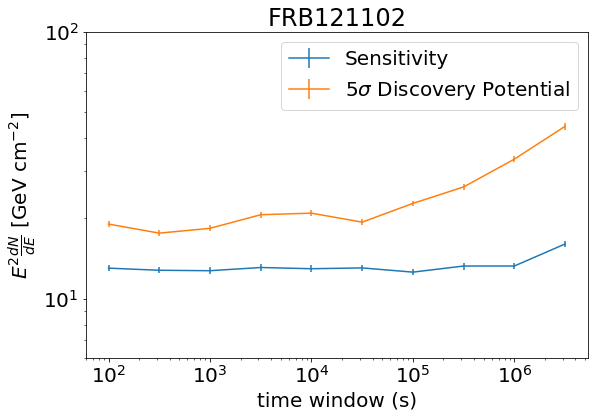

In [19]:
fig,axs = plt.subplots(1,figsize=(9,6))
ts=np.logspace(2,6.5,num=10)
axs.errorbar(ts, sens_n, yerr=dsens_n, label='Sensitivity')
axs.errorbar(ts, dp_n, yerr=ddp_n, label=r'5$\sigma$ Discovery Potential')
axs.set(ylabel=r'$E^2 \frac{dN}{dE}$ [GeV cm$^{-2}$]')
axs.semilogx()
axs.semilogy()
plt.legend(loc=0)
plt.ylim([6, 100])
axs.set_title('FRB121102')
plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat_E2dNdE.png'%('FRB121102'))

-->t=100 sec
sensitivity: 2.385 +/- 0.068 | DP: 3.314 +/- 0.087
-->t=316 sec
sensitivity: 2.438 +/- 0.058 | DP: 3.147 +/- 0.092
-->t=1000 sec
sensitivity: 2.521 +/- 0.075 | DP: 3.431 +/- 0.102
-->t=3162 sec
sensitivity: 2.584 +/- 0.076 | DP: 3.333 +/- 0.096
-->t=10000 sec
sensitivity: 2.418 +/- 0.070 | DP: 3.532 +/- 0.084
-->t=31622 sec
sensitivity: 2.420 +/- 0.058 | DP: 3.565 +/- 0.083
-->t=100000 sec
sensitivity: 2.330 +/- 0.069 | DP: 4.084 +/- 0.121
-->t=316227 sec
sensitivity: 2.332 +/- 0.069 | DP: 5.004 +/- 0.150
-->t=1000000 sec
sensitivity: 2.503 +/- 0.066 | DP: 6.184 +/- 0.165
-->t=3162277 sec
sensitivity: 2.553 +/- 0.076 | DP: 7.265 +/- 0.207


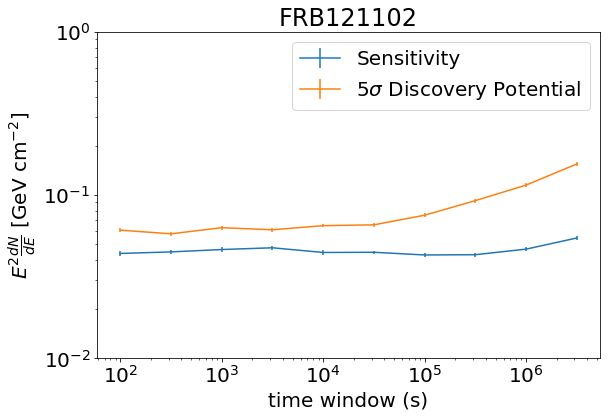

In [23]:
#FRB121102
sens_n, dsens_n, dp_n, ddp_n=deltat_plot(src_ind=wn, frb_name='FRB121102', physunits=True)

-->t=100 sec
sensitivity: 2.365 +/- 0.069 | DP: 1.894 +/- 0.049
-->t=316 sec
sensitivity: 2.313 +/- 0.066 | DP: 2.753 +/- 0.076
-->t=1000 sec
sensitivity: 2.289 +/- 0.057 | DP: 3.143 +/- 0.080
-->t=3162 sec
sensitivity: 2.308 +/- 0.062 | DP: 2.988 +/- 0.078
-->t=10000 sec
sensitivity: 2.342 +/- 0.061 | DP: 3.174 +/- 0.079
-->t=31622 sec
sensitivity: 2.253 +/- 0.062 | DP: 3.402 +/- 0.101
-->t=100000 sec
sensitivity: 2.549 +/- 0.071 | DP: 3.966 +/- 0.099
-->t=316227 sec
sensitivity: 2.357 +/- 0.067 | DP: 4.506 +/- 0.122
-->t=1000000 sec
sensitivity: 2.419 +/- 0.069 | DP: 4.979 +/- 0.147
-->t=3162277 sec
sensitivity: 2.346 +/- 0.068 | DP: 5.583 +/- 0.161


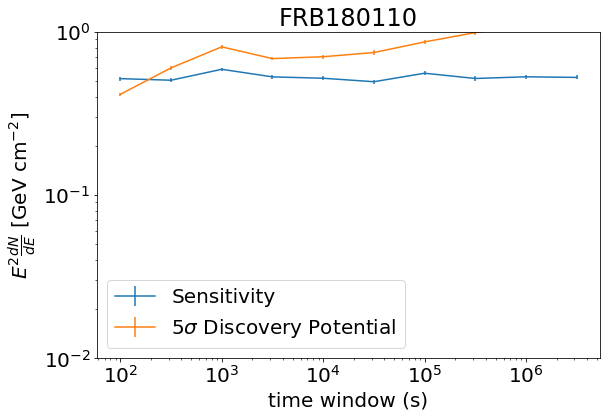

In [24]:
#FRB180110
sens_s, dsens_s, dp_s, ddp_s=deltat_plot(src_ind=ws, frb_name='FRB180110', physunits=True)

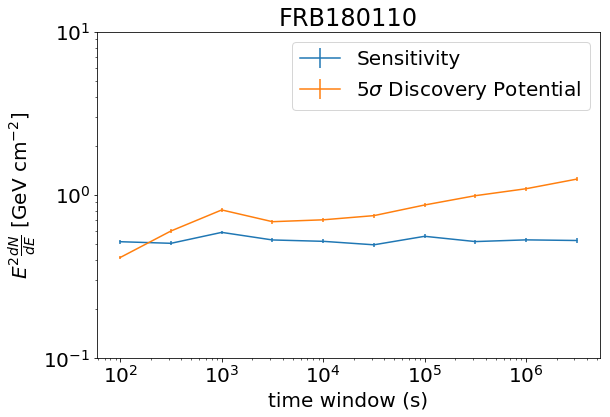

In [25]:
fig,axs = plt.subplots(1,figsize=(9,6))
ts=np.logspace(2,6.5,num=10)
axs.errorbar(ts, sens_s, yerr=dsens_s, label='Sensitivity')
axs.errorbar(ts, dp_s, yerr=ddp_s, label=r'5$\sigma$ Discovery Potential')
axs.set(ylabel=r'$E^2 \frac{dN}{dE}$ [GeV cm$^{-2}$]')
axs.semilogx()
axs.semilogy()
plt.legend(loc=0)
plt.ylim([0.1, 10])
axs.set_title('FRB180110')
plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat_E2dNdE.png'%('FRB180110'))

#### From Tutorials: bg sanity check for rate

In [20]:
a = ana[-1]
data, sig = a.data, a.sig #sig=MC info

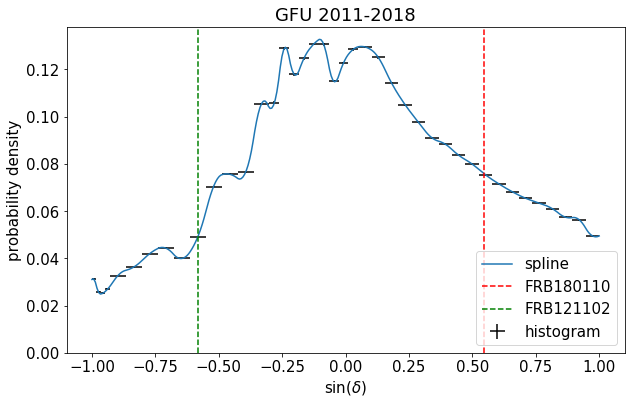

In [60]:
fig, ax = plt.subplots(figsize=(10,6))
hl.plot1d (ax, a.bg_space_param.h, crosses=True, color='k', label='histogram')
sd = np.linspace (-1, 1, 300)
ax.plot (sd, a.bg_space_param(sindec=sd), label='spline')
ax.set_ylim(0)
ax.set_title('GFU 2011-2018')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'probability density')

plt.axvline(np.sin(src180110_1000.dec[0]), ls='--',color='r', label='FRB180110')
plt.axvline(np.sin(src121102_1000.dec[0]), ls='--',color='g', label='FRB121102')
ax.legend(loc=4)
plt.savefig('./plots/spatial_pdf.png')

In [18]:
print(src180110_1000.dec[0])
print(src180110_1000.ra[0])
print(src121102_1000.dec[0])
print(src121102_1000.ra[0])

-0.6187192198319899
0.09548405449452309
0.5774761199800017
1.4492777776247914
